# Zatürre Tespiti için Derin Öğrenme

Proje, göğüs röntgenleri üzerinden pediatrik zatürre tespiti için uçtan uca bir yapay zeka modeli geliştirme sürecini özetlemektedir.

**1. VERİYİ TANIYALIM**

**Keşif ve Analiz:** Projenin ilk adımında, orijinal veri setinin yapısı incelenmiş ve sınıflar arasındaki (NORMAL/PNEUMONIA) sayısal dağılım analiz edilmiştir.

**Güvenilir Veri Bölümlemesi:** Modelin performansını en doğru şekilde ölçebilmek için, mevcut veri ayrımı yok sayılarak tüm görüntüler birleştirilmiş ve sınıf oranları korunarak (Stratified Split) tamamen yeni bir Train/Validation/Test seti oluşturulmuştur.

**Veri Temizliği ve Hazırlığı:** Eğitim sürecini riske atabilecek bozuk veya boş görüntü dosyaları sistematik olarak tespit edilip temizlenmiştir. Son olarak, modele verimli veri akışı sağlamak ve eğitim setini zenginleştirmek için veri artırma (augmentation) tekniklerini içeren DataLoader'lar hazırlanmıştır.

**2. MODELİN EĞİTİLMESİ**
**Mimari ve Yaklaşım:** Model olarak, görüntü tanımada kendini kanıtlamış, CNN tabanlı ResNet-18 mimarisi kullanılmıştır. Transfer Learning yaklaşımıyla, ImageNet üzerinde eğitilmiş hazır ağırlıklar kullanılarak hem eğitim süresi kısaltılmış hem de modelin performansı artırılmıştır.

**Gelişmiş Teknikler:** Modelin son katmanı, problemimize özel olarak Dropout ve Dense Layer ile yeniden tasarlanmıştır. Sınıf dengesizliğiyle mücadele etmek için hem ağırlıklandırılmış kayıp fonksiyonu hem de WeightedRandomSampler gibi gelişmiş yöntemler kullanılmıştır.

**Akıllı Eğitim Süreci:** Eğitim, öğrenme yavaşladığında öğrenme oranını otomatik düşüren bir zamanlayıcı (scheduler) ve modelin performansı iyileşmeyi bıraktığında aşırı öğrenmeyi önlemek için eğitimi durduran Early Stopping mekanizması ile yönetilmiştir.

**3. MODELİN DEĞERLENDİRİLMESİ**

**Nihai Performans Testi:** Eğitim bittikten sonra modelin genelleme yeteneği, daha önce hiç görmediği test seti üzerinde ölçülmüştür. Sonuçlar, Sınıflandırma Raporu (Precision, Recall, F1-Score) ve Karmaşıklık Matrisi ile detaylı bir şekilde analiz edilmiştir.

**Yorumlanabilirlik (Explainable AI):** Grad-CAM tekniği uygulanarak, modelin bir teşhis koyarken röntgen görüntüsünün tam olarak hangi bölgelerine odaklandığını gösteren ısı haritaları oluşturulmuş, böylece modelin kararlarına olan güven ve yorumlanabilirlik artırılmıştır.

**4. HİPERPARAMETRE OPTİMİZASYONU**

**En İyi Ayarları Bulma:** Modelin performansını en üst düzeye çıkarmak için, en iyi hiperparametre setini (öğrenme oranı, optimizer, dropout oranı vb.) bulmaya yönelik otomatik bir süreç yürütülmüştür.

**Hızlı ve Verimli Arama:** Bu süreçte, çok sayıda farklı ayar kombinasyonu, her biri için kısa ve hızlandırılmış "mini-eğitimler" çalıştırılarak test edilmiştir. 

In [1]:
import torch
import numpy as np
import random

# Tekrarlanabilirlik için bir tohum değeri belirle
SEED = 42

# Python'un kendi random modülü için tohumu ayarla
random.seed(SEED)

# NumPy için tohumu ayarla
np.random.seed(SEED)

# PyTorch için tohumu ayarla (hem CPU hem de GPU için)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# CUDA'nın deterministik algoritmaları kullanmasını sağla
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## VERİYİ TANIYALIM
"Pediatrik Zatürre Göğüs Röntgeni" veri setini keşfetmek amacıyla önce elimizde ne kadar veri olduğunu, bu verilerin sınıflara (Zatürre ve Normal) nasıl dağıldığına bakıyoruz.

 VERİ SETİ ÖZETİ

 TRAIN SET:
  - NORMAL: 1349 görüntü
  - PNEUMONIA: 3883 görüntü

- VAL seti bulunamadı, atlanıyor.

 TEST SET:
  - NORMAL: 234 görüntü
  - PNEUMONIA: 390 görüntü

 Toplam Görüntü Sayısı: 5856

 Eğitim Seti Dengesizlik Oranı: 2.88:1


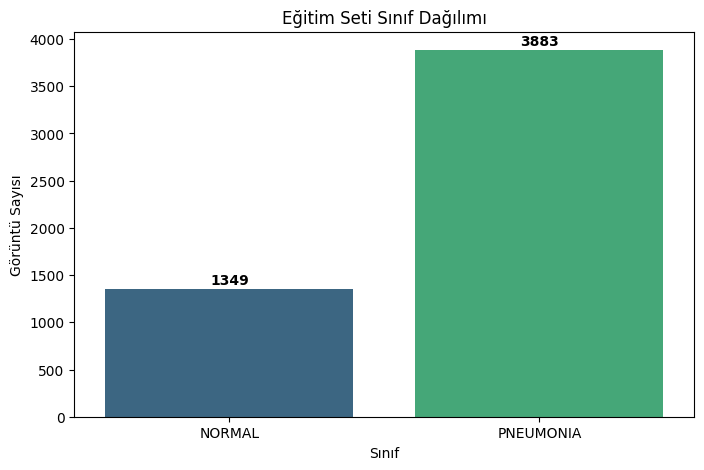

In [2]:
# === KÜTÜPHANELERİN YÜKLENMESİ VE VERİ SETİNİN KEŞFİ ===

import os
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# --- Veri Yollarını Tanımla ---
# Kaggle dataset path
BASE_DIR = Path("/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia")
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "val"  # Genellikle bir validation seti de bulunur, onu da ekleyelim
TEST_DIR = BASE_DIR / "test"


# --- Görüntü Sayılarını Hesapla ve Raporla ---
image_counts = {}
total_images = 0

print(" VERİ SETİ ÖZETİ\n" + "="*25)

# train, val, test setleri için döngü
for split in ["train", "val", "test"]:
    split_path = BASE_DIR / split
    if not split_path.exists():
        print(f"\n- {split.upper()} seti bulunamadı, atlanıyor.")
        continue

    print(f"\n {split.upper()} SET:")
    image_counts[split] = {}
    
    # NORMAL ve PNEUMONIA klasörleri için döngü
    for cls in sorted(os.listdir(split_path)): # sorted() ile her zaman aynı sırada (NORMAL, PNEUMONIA)
        cls_path = split_path / cls
        if not cls_path.is_dir(): continue # Sadece klasörleri say

        # Sadece resim dosyalarını say
        n_files = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        image_counts[split][cls] = n_files
        total_images += n_files
        print(f"  - {cls}: {n_files} görüntü")

print(f"\n Toplam Görüntü Sayısı: {total_images}")


# --- Veri Seti Dengesini Analiz Et ve Görselleştir (Eğitim Seti Üzerinden) ---
train_counts = image_counts.get("train", {}) # "train" seti yoksa hata vermemesi için
if train_counts:
    labels = list(train_counts.keys())
    counts = list(train_counts.values())
    
    # Dengesizlik oranını hesapla
    imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else 0
    print(f"\n Eğitim Seti Dengesizlik Oranı: {imbalance_ratio:.2f}:1")
    
    # Görselleştirme
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=counts, palette="viridis")
    plt.title('Eğitim Seti Sınıf Dağılımı')
    plt.xlabel('Sınıf')
    plt.ylabel('Görüntü Sayısı')
    # Barların üzerine sayıları yazdır
    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center', fontweight='bold')
    plt.show()

Orijinal veri setinin mevcut train/test ayrımını tamamen yok sayarak, tüm görüntüleri tek bir havuzda toplamak ve ardından bu havuzdan bilimsel olarak daha sağlam, dengeli ve tekrarlanabilir yeni bir train/val/test ayrımı oluşturuyoruz.

Bunu yaparken Stratified Split (Katmanlı Bölme) adı verilen kritik bir yöntem kullanır. Bu yöntem, orijinal veri setindeki sınıf oranlarının, oluşturulan her bir yeni sette (train, val, test) korunmasını sağlar.
-  Her şeyi birleştirip sıfırdan bölmek, test setinin model tarafından gerçekten hiç görülmediğini garanti altına alır.

In [3]:
# === VERİ SETİNİ SIFIRDAN OLUŞTURMA (STRATIFIED TRAIN/VAL/TEST SPLIT) ===

import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Kopyalama işleminin ilerlemesini göstermek için eklenti

# --- Gerekli Yolları ve Parametreleri Tanımla ---

ORIGINAL_DATA_DIR = Path("/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia")
# Oluşturulacak yeni veri setinin dizini
OUT_DIR = Path("/kaggle/working/chest_xray_split")

# Bölme oranları
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15 

# Rastgelelik durumunu sabitlemek için (sonuçların tekrarlanabilir olması için önemli)
RANDOM_STATE = 42

# --- Çıktı Klasör Yapısını Oluştur ---
if OUT_DIR.exists():
    print(f"'{OUT_DIR}' dizini zaten mevcut, temizleniyor...")
    shutil.rmtree(OUT_DIR)

print(f"Yeni klasör yapısı '{OUT_DIR}' içinde oluşturuluyor...")
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        (OUT_DIR / split / cls).mkdir(parents=True, exist_ok=True)

# --- Tüm Görüntüleri ve Etiketlerini Topla ---
all_files = []
all_labels = []
print("Tüm görüntüler taranıyor...")
for folder in ["train", "test", "val"]: # Orijinal veri setindeki tüm klasörleri tara
    folder_path = ORIGINAL_DATA_DIR / folder
    if not folder_path.exists(): continue
    
    for cls in ["NORMAL", "PNEUMONIA"]:
        cls_path = folder_path / cls
        if not cls_path.exists(): continue
        
        for file_path in cls_path.glob("*.jpeg"):
            all_files.append(file_path)
            all_labels.append(cls)

print(f"Toplam {len(all_files)} görüntü bulundu.")

# --- Katmanlı Bölme (Stratified Split) İşlemini Gerçekleştir ---
# İlk bölme: train ve (val + test) setlerini ayır
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=all_labels  # Sınıf oranlarını koru!
)

# İkinci bölme: val ve test setlerini ayır
# Kalan verinin yüzde kaçının val setine gideceğini hesapla
val_percentage_in_temp = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
val_files, test_files, _, _ = train_test_split(
    temp_files, temp_labels,
    train_size=val_percentage_in_temp,
    random_state=RANDOM_STATE,
    stratify=temp_labels # Sınıf oranlarını koru!
)

splits = {"train": train_files, "val": val_files, "test": test_files}

# --- Dosyaları Yeni Klasörlere Kopyala ---
print("Dosyalar yeni dizinlere kopyalanıyor...")
for split_name, files in splits.items():
    for file_path in tqdm(files, desc=f"Kopyalanıyor: {split_name}"):
        cls = file_path.parent.name
        shutil.copy(file_path, OUT_DIR / split_name / cls / file_path.name)

# --- Sonucu Doğrula ---
print("\n Veri seti başarıyla bölündü ve kopyalandı.")
print("\nYeni Veri Seti Dağılımı:")
for split in ["train", "val", "test"]:
    n_norm = len(list((OUT_DIR / split / "NORMAL").glob("*.jpeg")))
    n_pneu = len(list((OUT_DIR / split / "PNEUMONIA").glob("*.jpeg")))
    total_split = n_norm + n_pneu
    print(f"  - {split.upper():<5} -> NORMAL: {n_norm:<5} | PNEUMONIA: {n_pneu:<5} | TOPLAM: {total_split:<5} (%{total_split/len(all_files):.2f})")

Yeni klasör yapısı '/kaggle/working/chest_xray_split' içinde oluşturuluyor...
Tüm görüntüler taranıyor...
Toplam 5856 görüntü bulundu.
Dosyalar yeni dizinlere kopyalanıyor...


Kopyalanıyor: test: 100%|██████████| 879/879 [00:09<00:00, 93.87it/s]


 Veri seti başarıyla bölündü ve kopyalandı.

Yeni Veri Seti Dağılımı:
  - TRAIN -> NORMAL: 1108  | PNEUMONIA: 2991  | TOPLAM: 4099  (%0.70)
  - VAL   -> NORMAL: 237   | PNEUMONIA: 641   | TOPLAM: 878   (%0.15)
  - TEST  -> NORMAL: 238   | PNEUMONIA: 641   | TOPLAM: 879   (%0.15)


Sayısal verileri (görüntü sayılarını) anlaşılması kolay, gruplandırılmış bir sütun grafiğine dönüştürerek, veri bölme işleminin ne kadar başarılı olduğunu bir bakışta gösteriyoruz.

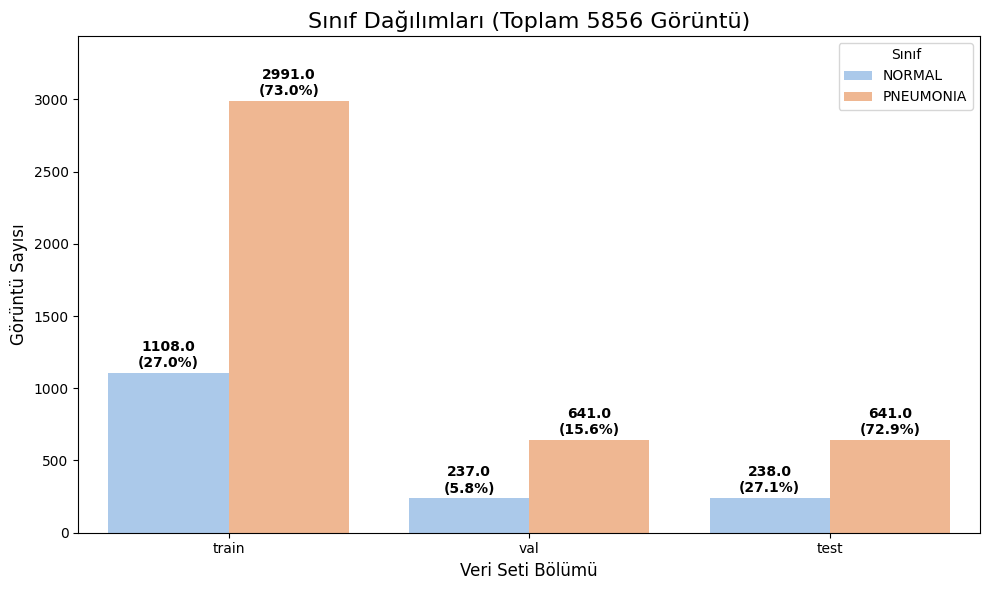

In [4]:
# === OLUŞTURULAN VERİ SETİ DAĞILIMINI GÖRSELLEŞTİRME ===

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- DataFrame Oluşturma ---
data_counts = []
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        n = len(list((OUT_DIR / split / cls).glob("*.jpeg")))
        data_counts.append({"split": split, "class": cls, "count": n})

df = pd.DataFrame(data_counts)
total_images = df['count'].sum() # Toplam resim sayısını hesapla

# --- Bar Grafiği Çizdirme ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="split", y="count", hue="class", data=df, palette="pastel")

plt.title(f"Sınıf Dağılımları (Toplam {total_images} Görüntü)", fontsize=16)
plt.xlabel("Veri Seti Bölümü", fontsize=12)
plt.ylabel("Görüntü Sayısı", fontsize=12)
plt.legend(title="Sınıf")

# --- Barların üzerine sayı ve yüzde ekleme ---
# Her bir bar grubuna (train, val, test) erişmek için
for p in ax.patches:
    # Toplam yüksekliği (her bir bölüm için) hesapla
    split_name = p.get_x()
    if split_name < 1:
        total_in_split = df[df['split'] == 'train']['count'].sum()
    elif split_name < 2:
        total_in_split = df[df['split'] == 'val']['count'].sum()
    else:
        total_in_split = df[df['split'] == 'test']['count'].sum()
        
    # Yüzdeyi hesapla
    percentage = f'{100 * p.get_height() / total_in_split:.1f}%'
    
    # Metni barın üzerine yerleştir
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20 # Sayıyı barın biraz üzerine yaz
    ax.text(x, y, f'{p.get_height()}\n({percentage})', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Y ekseni limitini metinlerin sığması için biraz artır
plt.ylim(0, df[df['split']=='train']['count'].max() * 1.15)
plt.tight_layout()
plt.show()

#### KOD ANALİZİ
Veri setindeki her bir görüntü dosyasının geçerli, bozulmamış ve okunabilir olduğundan emin olalım
- Boş dosya kontrolü
- Dosya bir görüntü olarak açılabiliyor mu?
- Dosyanın iç yapısı bozuk mu?
- Dosyanın formatı beklenen format mı?

In [5]:
# === VERİ TEMİZLİĞİ VE BÜTÜNLÜK KONTROLÜ ===
import os
from PIL import Image
from tqdm import tqdm

# Kontrol edilecek ana dizin 
DATA_TO_CHECK = OUT_DIR 

print(f"'{DATA_TO_CHECK}' dizinindeki görüntülerin bütünlüğü kontrol ediliyor...")

bad_files = []
# Tüm train/val/test klasörlerini gez
for split_folder in DATA_TO_CHECK.iterdir():
    if not split_folder.is_dir(): continue
    
    # Tüm sınıf (NORMAL/PNEUMONIA) klasörlerini gez
    for class_folder in split_folder.iterdir():
        if not class_folder.is_dir(): continue
        
        print(f"\n-> Taranıyor: {class_folder}")
        # Klasördeki her bir dosyayı kontrol et
        for image_file in tqdm(list(class_folder.iterdir())):
            try:
                # Dosya boyutu 0'dan büyük mü?
                if image_file.stat().st_size == 0:
                    bad_files.append(image_file)
                    continue # Bir sonraki dosyaya geç
                
                # Görüntü PIL ile açılabiliyor mu?
                img = Image.open(image_file)
                img.verify() # Dosya bütünlüğünü doğrula
                
                # Görüntü formatı gerçekten JPEG mi?
                if img.format.lower() not in ['jpeg', 'jpg', 'png']:
                    bad_files.append(image_file)

            except Exception as e:
                # Herhangi bir hata (bozuk dosya, okuma hatası vb.) olursa
                print(f"Hatalı dosya bulundu: {image_file} -> Hata: {e}")
                bad_files.append(image_file)

print("\n" + "="*50)
if not bad_files:
    print(" Tüm görüntüler temiz ve geçerli görünüyor. Sorun bulunamadı.")
else:
    print(f" {len(bad_files)} adet sorunlu dosya bulundu!")
    for f in bad_files:
        print(f"  - {f}")
    
    # Otomatik silme işlemi
    user_input = input("\nBu dosyaları silmek istiyor musunuz? (evet/hayır): ")
    if user_input.lower() == 'evet':
        print("Dosyalar siliniyor...")
        for f in bad_files:
            os.remove(f)
        print(f"{len(bad_files)} adet dosya başarıyla silindi.")
    else:
        print("Dosya silme işlemi iptal edildi.")
print("="*50)

'/kaggle/working/chest_xray_split' dizinindeki görüntülerin bütünlüğü kontrol ediliyor...

-> Taranıyor: /kaggle/working/chest_xray_split/val/NORMAL


100%|██████████| 237/237 [00:00<00:00, 4091.75it/s]



-> Taranıyor: /kaggle/working/chest_xray_split/val/PNEUMONIA


100%|██████████| 641/641 [00:00<00:00, 12351.15it/s]



-> Taranıyor: /kaggle/working/chest_xray_split/test/NORMAL


100%|██████████| 238/238 [00:00<00:00, 8599.62it/s]



-> Taranıyor: /kaggle/working/chest_xray_split/test/PNEUMONIA


100%|██████████| 641/641 [00:00<00:00, 10951.99it/s]



-> Taranıyor: /kaggle/working/chest_xray_split/train/NORMAL


100%|██████████| 1108/1108 [00:00<00:00, 8251.89it/s]



-> Taranıyor: /kaggle/working/chest_xray_split/train/PNEUMONIA


100%|██████████| 2991/2991 [00:00<00:00, 11883.72it/s]


 Tüm görüntüler temiz ve geçerli görünüyor. Sorun bulunamadı.


Bu süreçte, modelin ezber yapmasını önleyip genelleme yeteneğini artırmak amacıyla eğitim verilerine, özellikle rastgele Döndürme (Rotation), yatay/dikey Çevirme (Flip), hafif Yakınlaştırma/Uzaklaştırma (Zoom) ve Renk Değişimi (Color Jitter) gibi zengin bir veri artırma (augmentation) seti uygulanır. Kodun en kritik özelliklerinden biri, "NORMAL" ve "PNEUMONIA" sınıfları arasındaki sayısal dengesizliği gidermek için azınlık sınıfından daha sık örnek seçen bir WeightedRandomSampler kullanarak adil bir öğrenme ortamı yaratmasıdır. Son olarak, tüm bu işlenmiş ve zenginleştirilmiş veriler, paralel CPU çekirdekleri kullanarak veriyi verimli bir şekilde gruplayıp (batching) GPU'ya besleyen ve böylece eğitim sürecini hızlandıran DataLoader nesneleri aracılığıyla modele sunulmaya hazır hale getirilir.

In [6]:
# === DATALOADER & AUGMENTASYON & CLASS WEIGHTS ===
import os, torch, numpy as np
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

OUT_DIR = Path("/kaggle/working/chest_xray_split")
TRAIN_DIR = OUT_DIR / "train"
VAL_DIR   = OUT_DIR / "val"
TEST_DIR  = OUT_DIR / "test"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
BATCH_SIZE = 32

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05), scale=(0.9,1.1)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(VAL_DIR),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(str(TEST_DIR),  transform=eval_tfms)

class_names = train_ds.classes   # ['NORMAL', 'PNEUMONIA']

# --- Class weights (loss için) ---
# Label sayımını dataset.samples üzerinden yapıyoruz
train_labels = [s[1] for s in train_ds.samples]
class_counts = np.bincount(train_labels)  # [#NORMAL, #PNEUMONIA]
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_labels]

use_weighted_sampler = True  # dengesizliği daha iyi ele almak için
if use_weighted_sampler:
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    shuffle_train = False
else:
    sampler = None
    shuffle_train = True

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, shuffle=shuffle_train,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Class counts (train):", dict(zip(class_names, class_counts)))
print("Device:", DEVICE)

Class counts (train): {'NORMAL': 1108, 'PNEUMONIA': 2991}
Device: cpu


Bu kod, önceki adımda tanımlanan veri artırma (augmentation) işlemlerinin görsel bir sağlamasını yapmak amacıyla yazılmıştır. Kod, train_loader'dan rastgele bir grup (batch) görüntü çeker, bu gruptaki ilk 16 görüntüyü torchvision.utils.make_grid fonksiyonu yardımıyla tek bir ızgara (grid) üzerinde birleştirir ve ardından matplotlib kullanarak bu ızgarayı ekranda gösterir. Bu basit görselleştirme, döndürme, çevirme ve renk değiştirme gibi augmentasyonların beklendiği gibi çalışıp çalışmadığını ve görüntüler üzerinde çok agresif etkilere yol açıp açmadığını teyit etmenin en etkili yoludur, böylece saatler sürebilecek bir model eğitimine başlamadan önce veri hazırlama hattının doğruluğundan emin olunmasını sağlar.

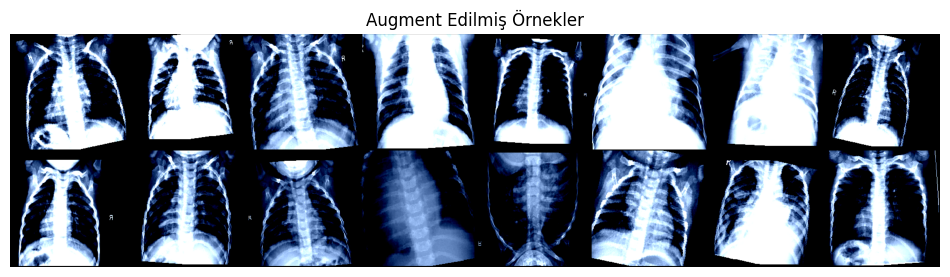

In [7]:
# Örnek grid
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dloader):
    x,y = next(iter(dloader))
    grid = make_grid(x[:16], nrow=8, normalize=True, value_range=(0,1))
    plt.figure(figsize=(12,4)); plt.imshow(grid.permute(1,2,0)); plt.axis("off"); plt.title("Augment Edilmiş Örnekler")
    plt.show()
show_batch(train_loader)

## MODELİN EĞİTİLMESİ

ImageNet veri seti üzerinde önceden eğitilmiş güçlü bir **ResNet-18 modelini** alarak, **Transfer Öğrenmesi (Transfer Learning)** tekniğiyle projemize uyarladık; bu işlem, modelin son katmanını kendi iki sınıfımız (NORMAL, PNEUMONIA) için yeniden tasarlayıp, aşırı öğrenmeyi **(overfitting)** engellemek amacıyla bir **Dropout** katmanı ekleyerek gerçekleştirilir. Modelin, sayıca az olan "NORMAL" sınıfını da etkin bir şekilde öğrenebilmesi için, bu sınıftaki hataları daha ağır cezalandıran ağırlıklandırılmış bir **CrossEntropyLos**s kayıp fonksiyonu kullanılır. Eğitim süreci, modern ve verimli bir optimizer olan **AdamW** ile yönetilirken, modelin öğrenmesi yavaşladığında öğrenme oranını otomatik olarak düşüren akıllı bir **ReduceLROnPlateau zamanlayıcısı** da devreye girer. Kodun en kritik ise eğitim döngüsüdür: model, doğrulama setindeki performansı 5 epoch boyunca iyileşme göstermezse **Erken Durdurma (Early Stopping)** mekanizması ile eğitimi otomatik olarak sonlandırır ve daha da önemlisi, tüm eğitim süreci boyunca en iyi performansı gösteren modelin ağırlıklarını hafızada tutarak, döngü bittiğinde bu en iyi modeli nihai sonuç olarak geri yükler, böylece elimizde sadece son modelin değil, mümkün olan en başarılı modelin olmasını garanti altına alır.

In [8]:
# === MODEL & EĞİTİM ===
import torch, time
import torch.nn as nn
from torchvision import models
import numpy as np

LR = 3e-4
WEIGHT_DECAY = 1e-4   # L2
EPOCHS = 15
PATIENCE = 5
DROPOUT_P = 0.3

# --- Model: ResNet18 (TL) ---
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(DROPOUT_P),
    nn.Linear(in_features, 2)   # 2 sınıf
)
model = model.to(DEVICE)

# --- Loss: class_weight ile CrossEntropy ---
class_w = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        if train_mode:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train_mode:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds==y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

history = {"tr_loss":[], "va_loss":[], "tr_acc":[], "va_acc":[]}
best_val_loss = np.inf
best_state = None
es = 0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    va_loss, va_acc = run_epoch(val_loader,   train_mode=False)
    scheduler.step(va_loss)

    history["tr_loss"].append(tr_loss); history["va_loss"].append(va_loss)
    history["tr_acc"].append(tr_acc);   history["va_acc"].append(va_acc)

    print(f"[{epoch:02d}] tr_loss={tr_loss:.4f} va_loss={va_loss:.4f} | tr_acc={tr_acc:.3f} va_acc={va_acc:.3f} | lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

    if va_loss < best_val_loss - 1e-4:
        best_val_loss = va_loss
        best_state = model.state_dict()
        es = 0
    else:
        es += 1
        if es >= PATIENCE:
            print("Early Stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


[01] tr_loss=0.1610 va_loss=0.1044 | tr_acc=0.922 va_acc=0.962 | lr=3.00e-04 | 643.1s
[02] tr_loss=0.1186 va_loss=0.9637 | tr_acc=0.942 va_acc=0.747 | lr=3.00e-04 | 594.8s
[03] tr_loss=0.1056 va_loss=0.1134 | tr_acc=0.951 va_acc=0.958 | lr=3.00e-04 | 599.8s
[04] tr_loss=0.0765 va_loss=0.1458 | tr_acc=0.963 va_acc=0.940 | lr=1.50e-04 | 603.5s
[05] tr_loss=0.0705 va_loss=0.1377 | tr_acc=0.966 va_acc=0.959 | lr=1.50e-04 | 600.4s
[06] tr_loss=0.0596 va_loss=0.0850 | tr_acc=0.970 va_acc=0.976 | lr=1.50e-04 | 605.5s
[07] tr_loss=0.0662 va_loss=0.1214 | tr_acc=0.971 va_acc=0.961 | lr=1.50e-04 | 604.1s
[08] tr_loss=0.0554 va_loss=0.2654 | tr_acc=0.975 va_acc=0.926 | lr=1.50e-04 | 604.8s
[09] tr_loss=0.0508 va_loss=0.1097 | tr_acc=0.976 va_acc=0.965 | lr=7.50e-05 | 604.3s
[10] tr_loss=0.0457 va_loss=0.0936 | tr_acc=0.980 va_acc=0.966 | lr=7.50e-05 | 607.4s
[11] tr_loss=0.0389 va_loss=0.1199 | tr_acc=0.982 va_acc=0.968 | lr=7.50e-05 | 600.3s
Early Stopping.


Modelin eğitim sürecinden elde edilen ham sayısal verileri rapora dönüştürüyoruz. Bunu yapmak için, epoch'lar arasındaki anlık dalgalanmaları ve gürültüyü filtreleyen hareketli ortalama ve medyan (moving average/median) gibi pürüzsüzleştirme teknikleri kullanarak kayıp (loss) ve doğruluk (accuracy) metriklerinin altındaki ana trendi belirgin bir şekilde ortaya çıkardık.

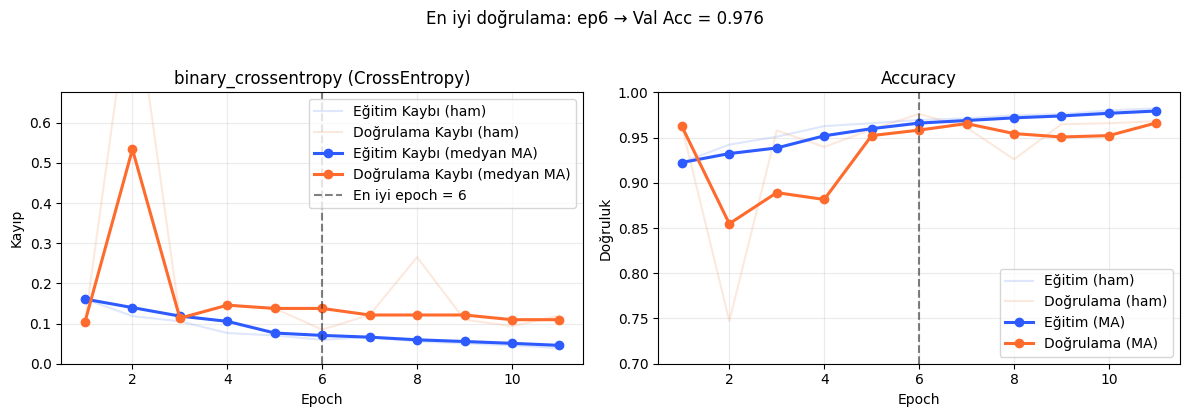

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def moving_mean(x, k=3):
    """Verilen bir dizinin 'k' pencereli hareketli ortalamasını hesaplar."""
    x = np.asarray(x, float)
    if len(x) < 2: return x # Çok kısa diziler için işlem yapma
    k = max(1, k) # Pencere boyutu en az 1 olmalı
    y = []
    for i in range(len(x)):
        s = max(0, i-k+1); e = i+1 # Her adımda, o anki ve önceki k-1 elemanı kapsayan bir pencere oluştur.
        y.append(x[s:e].mean())  # Penceredeki elemanların ortalamasını al ve listeye ekle.
    return np.array(y)

def moving_median(x, k=3):
    """Verilen bir dizinin 'k' pencereli hareketli medyanını hesaplar.
    Medyan, aykırı değerlere (ani sıçramalara) karşı ortalamadan daha dayanıklıdır."""
    x = np.asarray(x, float)
    if len(x) < 2: return x
    k = max(1, k)
    y = []
    for i in range(len(x)):
        s = max(0, i-k+1); e = i+1
        y.append(np.median(x[s:e]))
    return np.array(y)

def robust_ylim(values, top_pct=95, pad=1.15):
    """Grafiğin y-eksen limitlerini akıllıca ayarlar.
    En yüksek %5'lik aykırı değerleri yok sayarak grafiğin okunabilir kalmasını sağlar."""
    v = np.asarray(values, float)
    vmax = np.percentile(v, top_pct)
    vmin = min(v.min(), 0.0)
    return vmin, vmax*pad

# Eğitim geçmişinden epoch sayısını ve en iyi sonuçları çıkarıyoruz.
epochs = np.arange(1, len(history["tr_loss"])+1)
# np.argmax, en yüksek değerin 'indeksini' verir. Epoch numarası için +1 ekliyoruz.
best_ep = int(np.argmax(history["va_acc"])) + 1
best_va = float(np.max(history["va_acc"]))

# Metrikleri pürüzsüzleştirme (smoothing)
k = 3 # Hareketli ortalama/medyan için pencere boyutu
tr_loss_m = moving_median(history["tr_loss"], k)
va_loss_m = moving_median(history["va_loss"], k) # Kayıp için medyan
tr_acc_m  = moving_mean(history["tr_acc"], k) # Doğruluk için ortalama
va_acc_m  = moving_mean(history["va_acc"], k)

plt.figure(figsize=(12,4))

# ----- LOSS -----
plt.subplot(1,2,1)
plt.plot(epochs, history["tr_loss"], color="#7da0f6", alpha=.25, label="Eğitim Kaybı (ham)")
plt.plot(epochs, history["va_loss"], color="#f6a97d", alpha=.25, label="Doğrulama Kaybı (ham)")
plt.plot(epochs, tr_loss_m, color="#2d5bff", linewidth=2.2, marker="o", label="Eğitim Kaybı (medyan MA)")
plt.plot(epochs, va_loss_m, color="#ff6a2d", linewidth=2.2, marker="o", label="Doğrulama Kaybı (medyan MA)")
plt.axvline(best_ep, ls="--", color="#2b2b2b", alpha=.6, label=f"En iyi epoch = {best_ep}")
yl = robust_ylim(history["va_loss"], top_pct=95, pad=1.10)
plt.ylim(*yl)
plt.xlabel("Epoch"); plt.ylabel("Kayıp"); plt.title("binary_crossentropy (CrossEntropy)")
plt.grid(alpha=.25); plt.legend(loc="upper right")

# ----- ACC -----
plt.subplot(1,2,2)
plt.plot(epochs, history["tr_acc"], color="#7da0f6", alpha=.25, label="Eğitim (ham)")
plt.plot(epochs, history["va_acc"], color="#f6a97d", alpha=.25, label="Doğrulama (ham)")
plt.plot(epochs, tr_acc_m,  color="#2d5bff", linewidth=2.2, marker="o", label="Eğitim (MA)")
plt.plot(epochs, va_acc_m,  color="#ff6a2d", linewidth=2.2, marker="o", label="Doğrulama (MA)")
plt.axvline(best_ep, ls="--", color="#2b2b2b", alpha=.6)
plt.ylim(0.70, 1.00)
plt.xlabel("Epoch"); plt.ylabel("Doğruluk"); plt.title("Accuracy")
plt.grid(alpha=.25); plt.legend(loc="lower right")

plt.suptitle(f"En iyi doğrulama: ep{best_ep} → Val Acc = {best_va:.3f}", y=1.03, fontsize=12)
plt.tight_layout()
plt.show()

## MODELİN DEĞERLENDİRİLMESİ
Modelin, daha önce hiç görmediği test resimlerini modele gösterip tahminlerini topluyor. Sonra da bu tahminleri, modelin ne tür hatalar yaptığını (örneğin sağlıklı birini hasta olarak etiketledi mi?) net bir şekilde gösteren bir **Karmaşıklık Matrisi** ve detaylı bir karne niteliğindeki **Sınıflandırma Raporu** ile özetliyor

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.99      0.91      0.95       238
   PNEUMONIA       0.97      1.00      0.98       641

    accuracy                           0.97       879
   macro avg       0.98      0.95      0.96       879
weighted avg       0.97      0.97      0.97       879



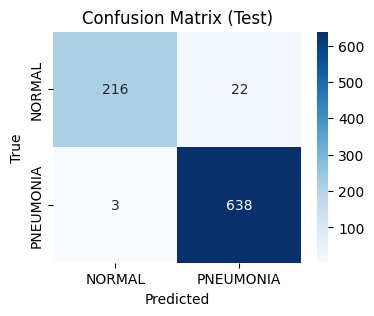

In [10]:
# === TEST DEĞERLENDİRME ===
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.show()

ROC Eğrisi ve AUC Skoru hesaplanıyor...


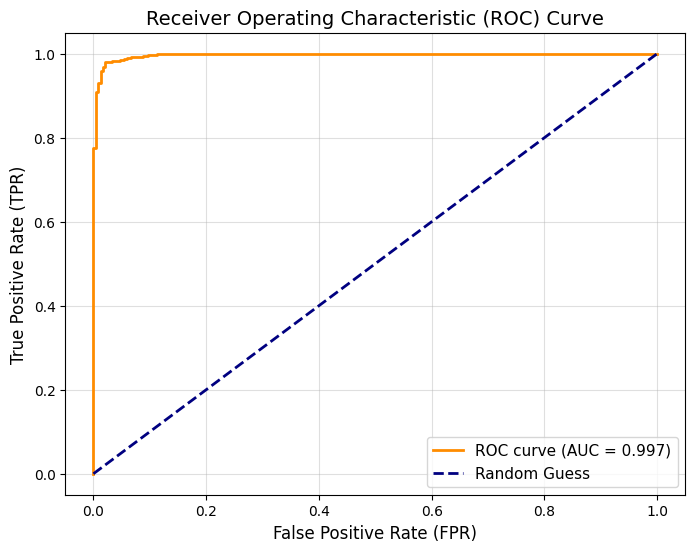

Hesaplanan AUC Skoru: 0.9970


In [11]:
# === ROC EĞRİSİ VE AUC SKORU ===
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch
import numpy as np

print("ROC Eğrisi ve AUC Skoru hesaplanıyor...")

# Modelin değerlendirme modunda olduğundan emin olalım
model.eval()

# Gerçek etiketleri ve modelin olasılık skorlarını saklamak için boş listeler
y_true_roc = []
y_scores_roc = []

# Gradyan hesaplamalarını durdurarak test verisi üzerinde döngüye girelim
with torch.no_grad():
    for x, y in test_loader:
        # Veriyi uygun cihaza gönder
        x = x.to(DEVICE)
        
        # Modelden logit'leri (ham çıktıları) al
        logits = model(x)
        
        # Logit'leri olasılıklara çevirmek için softmax uygula
        # dim=1, satır bazında softmax uygulanacağını belirtir
        probs = torch.softmax(logits, dim=1)
        
        # Pozitif sınıfın (PNEUMONIA) olasılıklarını al 
        # .cpu().numpy() ile tensörleri NumPy dizisine çevir
        scores = probs[:, 1].cpu().numpy()
        
        # Skorları ve gerçek etiketleri listelere ekle
        y_scores_roc.extend(scores.tolist())
        y_true_roc.extend(y.numpy().tolist())

# Listeleri NumPy dizisine çevir
y_true_roc = np.array(y_true_roc)
y_scores_roc = np.array(y_scores_roc)

# Scikit-learn ile ROC eğrisi için gerekli değerleri hesapla
# fpr: False Positive Rate, tpr: True Positive Rate
fpr, tpr, thresholds = roc_curve(y_true_roc, y_scores_roc)

# Eğrinin altında kalan alanı (AUC) hesapla
auc_score = roc_auc_score(y_true_roc, y_scores_roc)

# ROC eğrisini çiz
plt.figure(figsize=(8, 6)) # Grafiğin boyutunu ayarla
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess') # Rastgele tahmin çizgisi
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.4)
plt.show()

print(f"Hesaplanan AUC Skoru: {auc_score:.4f}")

In [12]:
# === MODELİ KAYDET ===
import torch
import os

MODEL_SAVE_PATH = "/kaggle/working/best_pneumonia_model.pth"

try:
    # Modeli kalıcı bir dosyaya kaydet
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print("="*50)
    print("BAŞARILI!")
    print(f"Model dosyası kaydedildi.")
    print(f"YOL: {MODEL_SAVE_PATH}")
    print("="*50)

except Exception as e:
    print(f"Bir hata oluştu: {e}")
    print("Lütfen model eğitiminin başarıyla tamamlandığından emin olun.")

BAŞARILI!
Model dosyası kaydedildi.
YOL: /kaggle/working/best_pneumonia_model.pth


Eğitilmiş modelin verdiği kararların arkasındaki görsel mantığı ortaya çıkarmayı amaçlıyoruz. **Grad-CAM** adı verilen bu teknik için, modelin son konvolüsyonel katmanına özel **"kancalar" (hooks)** takarak hem ileri geçişteki aktivasyonları (modelin ne "gördüğünü") hem de geri geçişteki gradyanları (hangi piksellerin önemli olduğunu) yakalar. Bu iki bilgiyi birleştirerek, modelin belirli bir teşhisi (örneğin "Zatürre") koyarken görüntünün hangi bölgelerine en çok odaklandığını gösteren bir **ısı haritası (heatmap)** oluşturur. Sonuç olarak, orijinal röntgen görüntüsü, bu ısı haritası ve ikisinin birleştirilmiş hali yan yana görselleştirilir; bu da bize modelin teşhisinin güvenilir olup olmadığını ve doğru anatomik bölgelere bakıp bakmadığını anlama imkanı sunarak yapay zekayı daha yorumlanabilir ve güvenilir kılar.

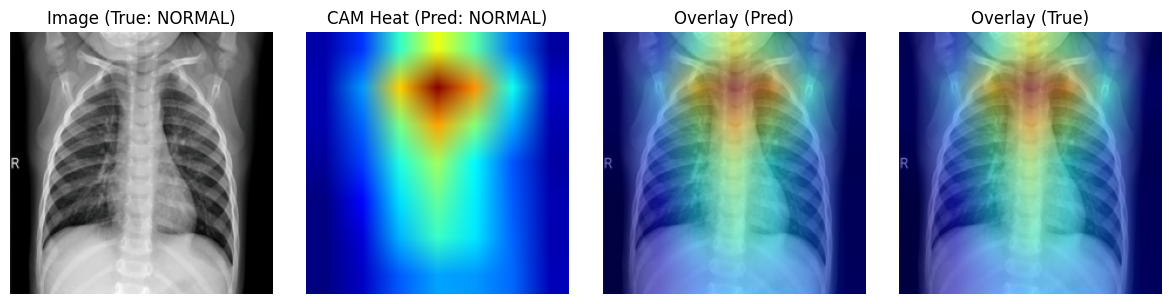

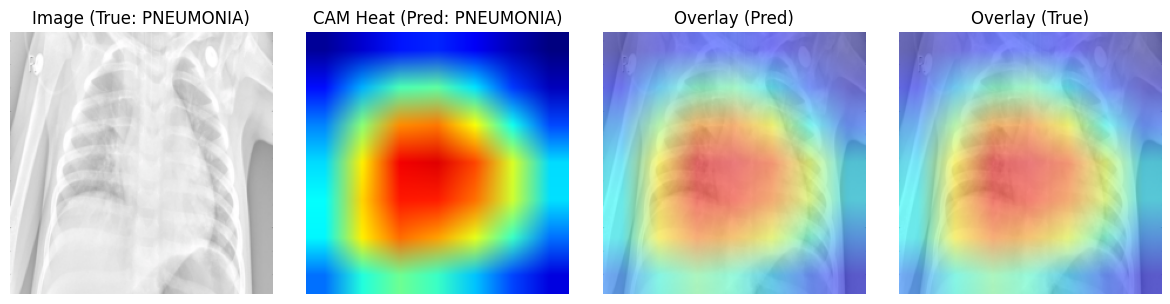

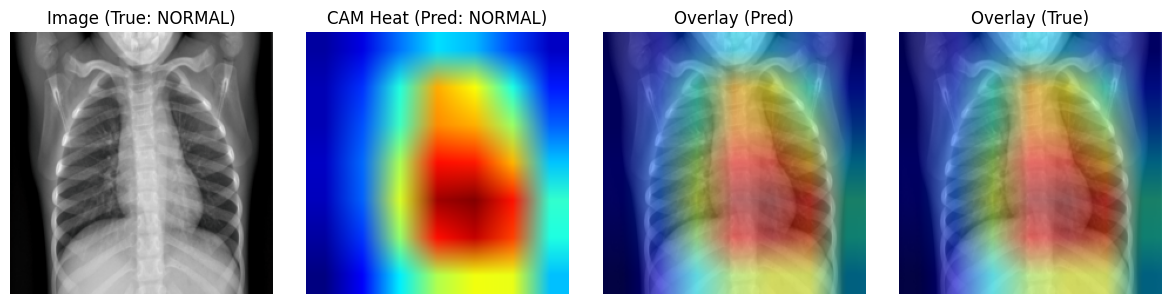

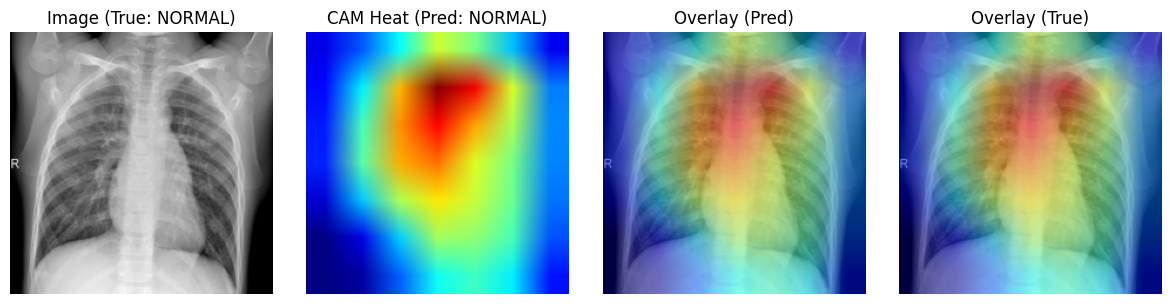

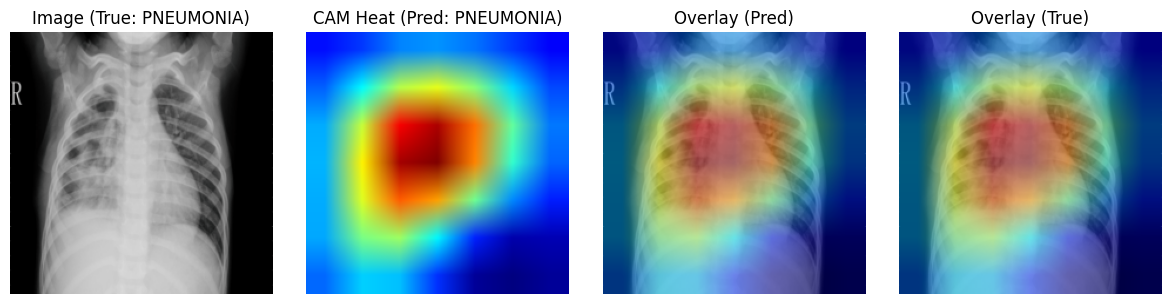

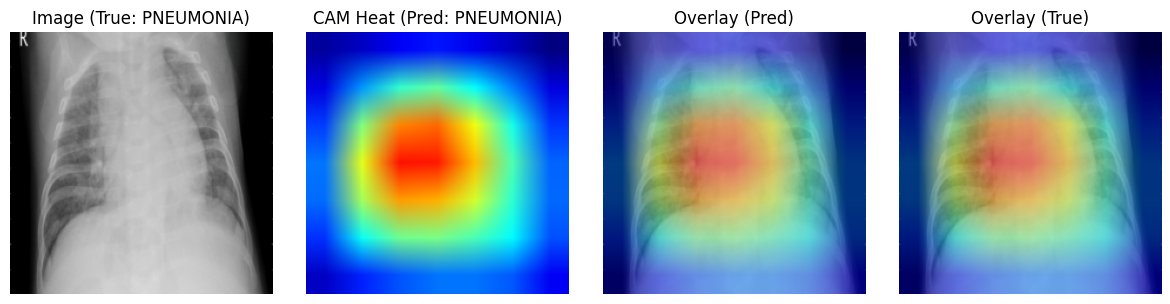

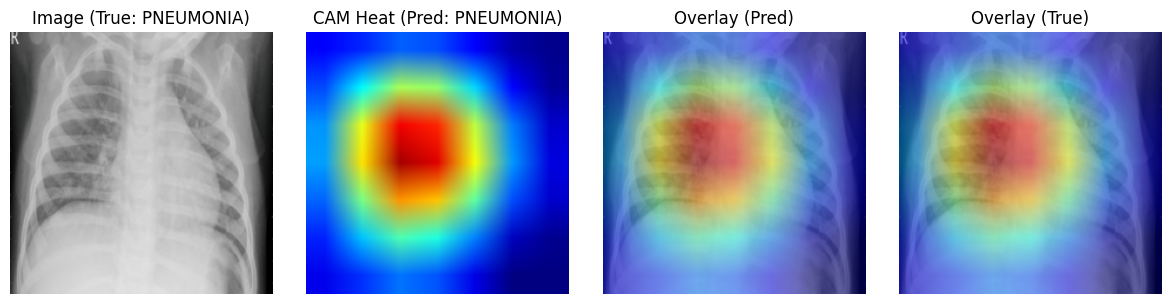

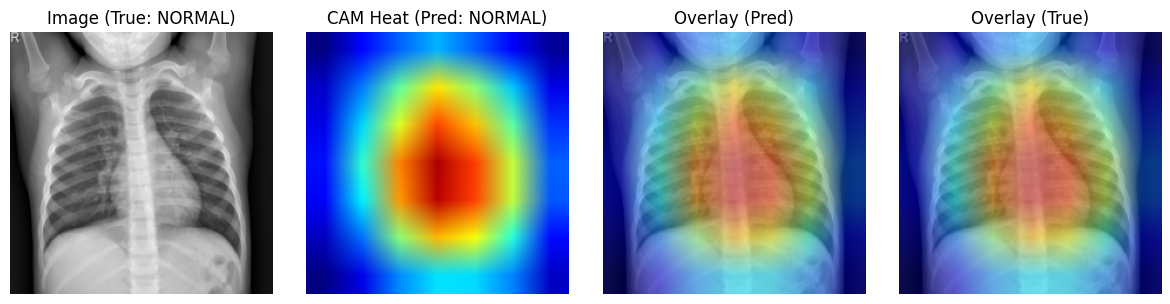

8 adet Grad-CAM görseli kaydedildi: cam_examples/


In [13]:
# === GRAD-CAM ===
import os, cv2, torch, random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

SAVE_DIR = "cam_examples"
os.makedirs(SAVE_DIR, exist_ok=True)
random.seed(42)

# --- target layer: resnet18 -> 'layer4'
target_layer = model.layer4

# --- hook'lar
activations = None
gradients = None
def f_hook(module, inp, out):            # forward
    global activations
    activations = out.detach()

def b_hook(module, grad_in, grad_out):   # backward (full)
    global gradients
    gradients = grad_out[0].detach()

f_handle = target_layer.register_forward_hook(f_hook)
b_handle = target_layer.register_full_backward_hook(b_hook)

# --- Denormalize (ImageNet)
def denorm(img_bchw):
    mean = torch.tensor([0.485,0.456,0.406], device=img_bchw.device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=img_bchw.device).view(1,3,1,1)
    x = (img_bchw*std + mean).clamp(0,1)[0].permute(1,2,0).detach().cpu().numpy()
    return (x*255).astype(np.uint8)

# --- Grad-CAM hesaplayıcı 
def gradcam_for_one(x1, target_class=None):  # x1: (1,3,H,W) on DEVICE
    global gradients, activations
    model.zero_grad(set_to_none=True)
    logits = model(x1)
    if target_class is None:
        cls_idx = int(logits.argmax(1).item())   # tahmin edilen sınıf
    else:
        cls_idx = int(target_class)               # kullanıcı hedefi 
    score = logits[0, cls_idx]
    score.backward()

    w = gradients.mean(dim=(2,3), keepdim=True)           # [B,C,1,1]
    cam = (w * activations).sum(dim=1, keepdim=True)      # [B,1,H',W']
    cam = F.relu(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam[0,0].detach().cpu().numpy(), cls_idx

# --- CAM'i orijinal görsele bindir
def overlay_cam(orig_uint8, cam_01, alpha=0.5):
    heat = cv2.applyColorMap((cam_01*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    heat = cv2.resize(heat, (orig_uint8.shape[1], orig_uint8.shape[0]))
    return (alpha*heat + (1-alpha)*orig_uint8).astype(np.uint8), heat

# === N örnek üzerinde çalıştır (dengeli örnekleme) ===
model.eval()
N_EXAMPLES = 8  # toplam örnek

# test_ds varsa ondan dengeli indeks seç (ImageFolder benzeri: (img, label))
labels = [int(test_ds[i][1]) for i in range(len(test_ds))]
num_classes = len(class_names)
idx_by_class = {c: [i for i, y in enumerate(labels) if y == c] for c in range(num_classes)}
per_class = max(1, N_EXAMPLES // num_classes)

picked = []
for c in range(num_classes):
    take = min(per_class, len(idx_by_class[c]))
    if take > 0:
        picked += random.sample(idx_by_class[c], take)
# kalanları doldur (N_EXAMPLES'a tamamla)
if len(picked) < N_EXAMPLES:
    rest = [i for i in range(len(test_ds)) if i not in picked]
    extra = random.sample(rest, min(N_EXAMPLES - len(picked), len(rest)))
    picked += extra
random.shuffle(picked)
picked = picked[:N_EXAMPLES]

for k, idx in enumerate(picked):
    img, y_true = test_ds[idx]                     # (C,H,W), label
    x1 = img.unsqueeze(0).to(DEVICE, non_blocking=True)

    # CAM (pred sınıfına) ve (true sınıfına)
    cam_pred, pred_idx = gradcam_for_one(x1, target_class=None)
    cam_true, _        = gradcam_for_one(x1, target_class=y_true)

    orig = denorm(x1)
    overlay_pred, heat_pred = overlay_cam(orig, cam_pred, alpha=0.5)
    overlay_true, heat_true = overlay_cam(orig, cam_true, alpha=0.5)

    # 1x4 panel: Orijinal | CAM(pred heat) | Overlay(pred) | Overlay(true)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(1,4,1); plt.imshow(orig);        plt.title(f"Image (True: {class_names[y_true]})"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(heat_pred);   plt.title(f"CAM Heat (Pred: {class_names[pred_idx]})"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(overlay_pred);plt.title("Overlay (Pred)"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(overlay_true);plt.title("Overlay (True)"); plt.axis("off")
    plt.tight_layout()

    fname = f"cam_{k:02d}_true-{class_names[y_true]}_pred-{class_names[pred_idx]}.png"
    fig.savefig(os.path.join(SAVE_DIR, fname), dpi=150)
    plt.show()
    plt.close(fig)

print(f"{len(picked)} adet Grad-CAM görseli kaydedildi: {SAVE_DIR}/")

# --- hook'ları temizle
f_handle.remove(); b_handle.remove()

## HİPERPARAMETRE OPTİMİZASYONU
En iyi model ayarlarını bulmak için son derece hızlı bir hiperparametre arama süreci yürütüyoruz. Kod, tüm olası ayarları saatlerce denemek yerine, optimizer, öğrenme oranı, dropout ve weight decay gibi kritik parametreler için tanımlanmış bir "menüden" rastgele 12 farklı kombinasyon seçer. Her bir kombinasyon için, ResNet-18 modelinin ana gövdesini dondurarak ve sadece son katmanı çok kısa bir süre (2 epoch), hatta epoch'ları tamamlamadan, sadece birkaç düzine batch üzerinde eğiterek bir **"mini-eğitim"** gerçekleştirir. Bu hızlı denemeler sonucunda her bir ayar setinin potansiyelini ölçer, sonuçları sıralar, en iyi 5 tanesini raporlar ve son olarak, en başarılı performansı gösteren "kazanan" hiperparametre setini net bir şekilde sunar.

[Trial 01] opt=adamw  lr=0.0001  wd=0.0001 drop=0.4 -> best_val_acc=0.2711
[Trial 02] opt=adamw  lr=0.0001  wd=0.0003 drop=0.2 -> best_val_acc=0.2779
[Trial 03] opt=adamw  lr=0.001   wd=0.0003 drop=0.4 -> best_val_acc=0.7073
[Trial 04] opt=adamw  lr=0.001   wd=0      drop=0.3 -> best_val_acc=0.7392
[Trial 05] opt=adamw  lr=0.0001  wd=0      drop=0.2 -> best_val_acc=0.4784
[Trial 06] opt=adamw  lr=0.001   wd=0.0003 drop=0.2 -> best_val_acc=0.7039
[Trial 07] opt=sgd_mom lr=0.0001  wd=0.0003 drop=0.3 -> best_val_acc=0.4886
[Trial 08] opt=sgd_mom lr=0.0001  wd=0.0003 drop=0.2 -> best_val_acc=0.4408
[Trial 09] opt=sgd_mom lr=0.0003  wd=0      drop=0.3 -> best_val_acc=0.5729
[Trial 10] opt=adamw  lr=0.0003  wd=0      drop=0.2 -> best_val_acc=0.4522
[Trial 11] opt=sgd_mom lr=0.0001  wd=0.0001 drop=0.3 -> best_val_acc=0.5137
[Trial 12] opt=sgd_mom lr=0.0001  wd=0.0001 drop=0.4 -> best_val_acc=0.4465

Bitti. Toplam süre: 3590.5s

TOP-5:
(4, {'optimizer': 'adamw', 'lr': 0.001, 'dropout': 0.3, 'w

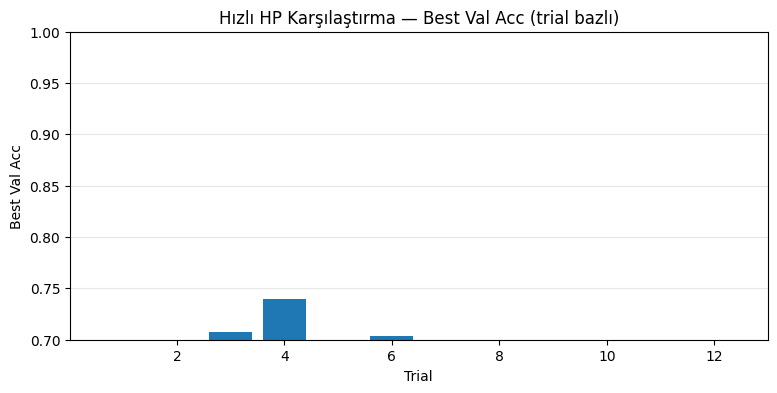

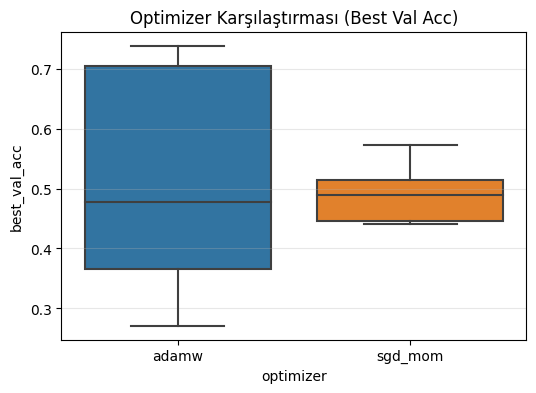


En iyi hiperparametreler: {'optimizer': 'adamw', 'lr': 0.001, 'dropout': 0.3, 'wd': 0.0}


In [14]:
# === HIZLI HP KARŞILAŞTIRMA (ResNet18 - FC fine-tune) ===
import time, random, copy
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

# ----- Hız ayarları -----
EPOCHS_CMP       = 2        # her denemede kısa eğitim
MAX_STEPS_TRAIN  = 60       # her epoch en fazla 60 batch
MAX_STEPS_VAL    = 40       # val'de en fazla 40 batch
AMP               = (DEVICE == "cuda")

# ----- Arama uzayı ve kaç deneme -----
N_TRIALS = 12   # Toplam 12 farklı hiperparametre kombinasyonu denenecek.
SPACE = {
    "optimizer": ["adamw", "sgd_mom"],     # iki iyi aday
    "lr":        [1e-4, 3e-4, 1e-3], # Öğrenme oranları
    "dropout":   [0.2, 0.3, 0.4], # Dropout oranları
    "wd":        [0.0, 1e-4, 3e-4], # Weight decay (regülarizasyon)
}
random.seed(42)

def sample_hp():
    """SPACE menüsünden rastgele bir hiperparametre seti seçer."""
    return {
        "optimizer": random.choice(SPACE["optimizer"]),
        "lr":        random.choice(SPACE["lr"]),
        "dropout":   random.choice(SPACE["dropout"]),
        "wd":        random.choice(SPACE["wd"]),
    }
# --- Hızlı Denemeler İçin Model ve Eğitim Fonksiyonları ---
def build_resnet18(dropout=0.3):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_f = m.fc.in_features
    m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, len(class_names)))
    return m

def freeze_backbone(m, freeze=True):
    """Modelin gövdesini dondurur, sadece son katman eğitilir. Bu en büyük hız artışını sağlar."""
    if not freeze: return
    for n, p in m.named_parameters():
        if not n.startswith("fc"):
            p.requires_grad = False

def make_optimizer(name, params, lr, wd):
    """Verilen isme göre optimizer oluşturur."""
    name = name.lower()
    if name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=wd)
    elif name == "sgd_mom":
        return torch.optim.SGD(params, lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)
    else:
        raise ValueError("unknown optimizer")

criterion = nn.CrossEntropyLoss(weight=class_w)

def train_k_epochs(model, optimizer, train_loader, val_loader,
                   k=EPOCHS_CMP, max_steps_train=None, max_steps_val=None, amp=AMP):
    """Hızlandırılmış eğitim fonksiyonu. max_steps parametreleri ile epoch'ları tamamlamadan çıkar."""
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    tr_hist, va_hist = [], []
    model.to(DEVICE)

    for _ in range(k):
         # --- Kısmi Eğitim ---
        model.train()
        tr_correct = tr_total = 0
        for step, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=amp):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            tr_correct += (logits.argmax(1) == yb).sum().item()
            tr_total   += xb.size(0)
            if max_steps_train and (step + 1) >= max_steps_train:
                break
        tr_hist.append(tr_correct / max(1, tr_total))

        # --- Kısmi Doğrulama --
        model.eval()
        va_correct = va_total = 0
        with torch.no_grad():
            for step, (xb, yb) in enumerate(val_loader):
                xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                logits = model(xb)
                va_correct += (logits.argmax(1) == yb).sum().item()
                va_total   += xb.size(0)
                if max_steps_val and (step + 1) >= max_steps_val:
                    break
        va_hist.append(va_correct / max(1, va_total))

    return tr_hist, va_hist

# ----- Hızlı tarama döngüsü -----
results = []  # (trial, hp, best_val_acc)
t_start = time.time()
for t in range(1, N_TRIALS + 1):
    hp = sample_hp()
    m = build_resnet18(dropout=hp["dropout"])
    freeze_backbone(m, True)  # Sadece son katmanı eğitmek üzere dondur
    opt = make_optimizer(hp["optimizer"],
                         filter(lambda p: p.requires_grad, m.parameters()),
                         lr=hp["lr"], wd=hp["wd"])
    # Minyatür eğitimi çalıştır
    tr_curve, va_curve = train_k_epochs(
        m, opt, train_loader, val_loader,
        k=EPOCHS_CMP,
        max_steps_train=MAX_STEPS_TRAIN,
        max_steps_val=MAX_STEPS_VAL,
        amp=AMP
    )
    best_va = max(va_curve)
    results.append((t, hp, best_va))
    print(f"[Trial {t:02d}] opt={hp['optimizer']:<6} lr={hp['lr']:<7g} wd={hp['wd']:<6g} drop={hp['dropout']}"
          f" -> best_val_acc={best_va:.4f}")

print(f"\nBitti. Toplam süre: {time.time() - t_start:.1f}s")

# ----- Sonuçların özeti + grafik -----
# En iyi 5'i yazdır
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
print("\nTOP-5:")
for r in results_sorted[:5]:
    print(r)

# Barplot: trial vs best_val_acc
plt.figure(figsize=(9,4))
plt.bar([r[0] for r in results], [r[2] for r in results])
plt.title("Hızlı HP Karşılaştırma — Best Val Acc (trial bazlı)")
plt.xlabel("Trial"); plt.ylabel("Best Val Acc"); plt.ylim(0.7, 1.0); plt.grid(axis="y", alpha=.3)
plt.show()

# optimizer bazlı kutu grafiği
try:
    import pandas as pd, seaborn as sns
    df = pd.DataFrame([{"trial":r[0], "optimizer":r[1]["optimizer"], "lr":r[1]["lr"],
                        "dropout":r[1]["dropout"], "wd":r[1]["wd"], "best_val_acc":r[2]} for r in results])
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="optimizer", y="best_val_acc")
    plt.title("Optimizer Karşılaştırması (Best Val Acc)"); plt.grid(axis="y", alpha=.3)
    plt.show()
except Exception as e:
    print("Pandas/Seaborn yoksa bu kısım atlandı:", e)

# En iyi hp ile uzun eğitim için kolay erişim:
best_hp = results_sorted[0][1]
print("\nEn iyi hiperparametreler:", best_hp)